# <center>Stock Price Prediction Using Technical Indicator Data</center>

### <center>Chris Davis </center>
<center>October, 2021 </center>

## Table of Contents
- [Introduction](#Introduction)
- [Data Collection](#Data-Collection)
- [Data Preparation](#Data-Preparation)
- [Analysis](#Analysis)
- [Data Summary](#Data-Summary)
- [Bibliography](#Bibliography)

## Introduction

***Research Question***

Can a random forest model predict stock price using only technical indicators as inputs?
          
***Context***

The price of a given stock is, in theory, an estimation of the value of the company. Although there are external and subjective elements that are included in a valuation (predicted industry growth, confidence in management, growth potential etc.), the foundation of the valuation is a product of the financial data and subsequent technical indicators that are used to analyze performance. In this study, a random forest regression model will be used to attempt to accurately predict stock price by using financial data. The value of an accurate model would be its ability to identify both stocks that are significantly under-valued and would be good investments as well stocks that are over-valued and would not be good investments.

## Data Collection

Publicly available financial and technical indicator data is collected from the Yahoo Finance database via API. Because the dependent variable is stock price, any data variable that contains price (current & past) in its formulation will not be collected.

Limitations: The dataset is limited by the completeness of the data made available by public reporting requirements as well as data availability within Yahoo! Finance. Additionally, the financial data is only reported at the end of each quarter and may fluctuate in between reporting periods.

Delimitations: The dataset will be reduced by only including entries which contain all data points. In order to minimize the effect of quarterly reporting, the stock price will be collected from the time of reporting.

In total, there are 46 available metrics for analysis:

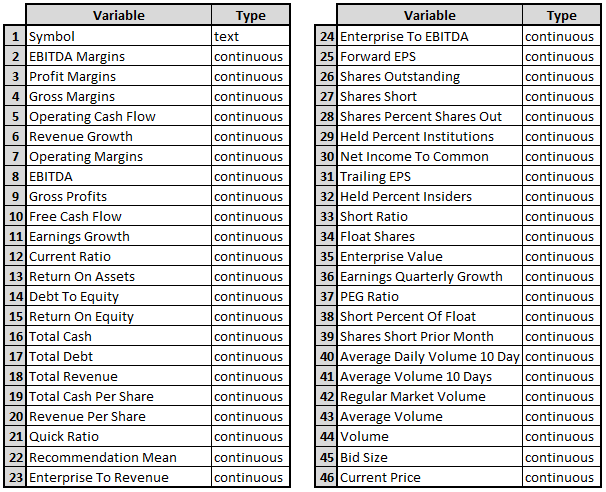


***Total Observations***: 10,346

***Code Used for Data Collection***:

In [ ]:
#import packages
import yfinance as yf
import pandas as pd
from yahoo_fin import stock_info as si
import os

# Set directory
os.chdir("C:/Users/Chris/Documents/WGU/Capstone")

#Define query variables
return_vars = ['symbol','ebitdaMargins','profitMargins','grossMargins',
               'operatingCashflow','revenueGrowth','operatingMargins','ebitda',
               'grossProfits','freeCashflow','earningsGrowth','currentRatio',
               'returnOnAssets','debtToEquity','returnOnEquity','totalCash',
               'totalDebt','totalRevenue','totalCashPerShare','revenuePerShare',
               'quickRatio','recommendationMean','enterpriseToRevenue',
               'enterpriseToEbitda','forwardEps','sharesOutstanding',
               'sharesShort','sharesPercentSharesOut','heldPercentInstitutions',
               'netIncomeToCommon','trailingEps','heldPercentInsiders',
               'shortRatio','floatShares','enterpriseValue','earningsQuarterlyGrowth',
               'pegRatio','shortPercentOfFloat','sharesShortPriorMonth',
               'averageDailyVolume10Day','averageVolume10days',
               'regularMarketVolume','averageVolume','volume','bidSize','Current Price']

#Define dataframe to store results
tkr_database = pd.DataFrame(columns = return_vars)
                        
#Create stock ticker list
ticker_list = si.tickers_nasdaq()
ticker_list.extend(si.tickers_other())

#Fetch results via Yahoo Finance API
missing_list = []

for tkr in ticker_list:
    stk_tkr = yf.Ticker(tkr)
    NewEntry = []

    try:
        X = stk_tkr.info 
        NewEntry = [X.get(key) for key in return_vars]
        tkr_database.loc[len(tkr_database)] = NewEntry  
    except:
        missing_list = missing_list.append(tkr)

# Save Results
tkr_database.to_csv("StockMarketDatabase.csv")

## Data Preparation

***Process Overview:***
- Load compiled database into workspace
- Convert variable names to common form to increase legibility
- Evaluate data sparsity
- Remove variables with high rates of missing data
- Drop missing values
- Evaluate dependent variable distribution
- Remove outliers
- Scale independent variables

In [1]:
#Import Packages
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.ticker as mtick
from IPython.display import display

#Set directory
os.chdir("C:/Users/Chris/Documents/WGU/Capstone")

#Import Database
df_raw = pd.read_csv("StockMarketDatabase.csv")

In [2]:
df_raw.describe()

,ebitdaMargins,profitMargins,grossMargins,operatingCashflow,revenueGrowth,operatingMargins,ebitda,grossProfits,freeCashflow,earningsGrowth,...,pegRatio,shortPercentOfFloat,sharesShortPriorMonth,averageDailyVolume10Day,averageVolume10days,regularMarketVolume,averageVolume,volume,bidSize,currentPrice
count,6753.000000,6753.000000,6753.000000,5.971000e+03,5156.000000,6753.000000,4.643000e+03,5.472000e+03,4.519000e+03,2.283000e+03,...,3119.000000,4946.000000,6.356000e+03,9.843000e+03,9.612000e+03,1.031900e+04,9.612000e+03,1.008800e+04,9971.000000,6932.000000
mean,0.016677,0.431638,0.317409,4.890560e+09,5.470856,-15.185792,1.274071e+10,4.315558e+10,3.129724e+09,1.320350e+03,...,15.181741,0.047061,3.522111e+06,1.173289e+06,1.169692e+06,7.631572e+05,1.007482e+06,7.646092e+05,1946.595126,45.665425
std,0.403265,8.477649,0.428082,4.456680e+11,287.141291,362.471547,3.031798e+11,1.209107e+12,7.065943e+10,4.441976e+04,...,580.058300,0.074009,8.936357e+06,9.593082e+06,9.593555e+06,9.959881e+06,4.009418e+06,1.001926e+07,7011.814731,137.098476
min,-2.967520,-2.993940,-2.996400,-2.720000e+13,-1.000000,-15338.571000,-1.641500e+10,-1.231700e+10,-6.680000e+11,-9.890000e-01,...,-18645.800000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.059900
25%,0.000000,0.000000,0.000000,-6.138846e+06,0.013000,-0.012460,-1.432271e+07,1.917602e+07,-9.662375e+06,-3.500000e-03,...,0.070000,0.010700,6.496700e+04,1.799250e+04,1.936575e+04,5.046000e+03,2.273500e+04,5.396500e+03,800.000000,8.729975
50%,0.000000,0.000000,0.282340,1.870827e+07,0.200000,0.026960,3.877678e+07,1.527330e+08,1.565888e+07,4.580000e-01,...,1.080000,0.027100,7.777985e+05,1.132000e+05,1.190060e+05,4.967300e+04,1.337240e+05,5.258150e+04,1000.000000,15.570000
75%,0.152980,0.134350,0.598570,2.382140e+08,0.514000,0.199850,4.238500e+08,8.010135e+08,2.088397e+08,1.448000e+00,...,2.480000,0.061300,3.326446e+06,5.880310e+05,6.032845e+05,3.130450e+05,6.403748e+05,3.199690e+05,1300.000000,40.857500
max,3.748870,634.214050,1.773650,1.370000e+13,20469.477000,826.000000,1.530000e+13,8.210000e+13,2.870000e+12,1.501103e+06,...,18361.500000,3.421300,2.647839e+08,6.330518e+08,6.330518e+08,9.253752e+08,1.537236e+08,9.253752e+08,321800.000000,4843.310000


The variables in the database are all commonly used financial metrics. For increased legibility, they are converted to their common names.

In [3]:
#Rename columns
column_names = {'symbol' : 'Symbol',
                'ebitdaMargins' : 'EBITDA Margins',
                'profitMargins' : 'Profit Margins',
                'grossMargins' : 'Gross Margins',
                'operatingCashflow' : 'Operating Cash Flow',
                'revenueGrowth' : 'Revenue Growth',
                'operatingMargins' : 'Operating Margins',
                'ebitda' : 'EBITDA',
                'grossProfits' : 'Gross Profits',
                'freeCashflow' : 'Free Cash Flow',
                'earningsGrowth' : 'Earnings Growth',
                'currentRatio' : 'Current Ratio',
                'returnOnAssets' : 'Return On Assets',
                'debtToEquity' : 'Debt To Equity',
                'returnOnEquity' : 'Return On Equity',
                'totalCash' : 'Total Cash',
                'totalDebt' : 'Total Debt',
                'totalRevenue' : 'Total Revenue',
                'totalCashPerShare' : 'Total Cash Per Share',
                'revenuePerShare' : 'Revenue Per Share',
                'quickRatio' : 'Quick Ratio',
                'recommendationMean' : 'Recommendation Mean',
                'enterpriseToRevenue' : 'Enterprise To Revenue',
                'enterpriseToEbitda' : 'Enterprise To EBITDA',
                'forwardEps' : 'Forward EPS',
                'sharesOutstanding' : 'Shares Outstanding',
                'sharesShort' : 'Shares Short',
                'sharesPercentSharesOut' : 'Shares Percent Shares Out',
                'heldPercentInstitutions' : 'Held Percent Institutions',
                'netIncomeToCommon' : 'Net Income To Common',
                'trailingEps' : 'Trailing EPS',
                'heldPercentInsiders' : 'Held Percent Insiders',
                'shortRatio' : 'Short Ratio',
                'floatShares' : 'Float Shares',
                'enterpriseValue' : 'Enterprise Value',
                'earningsQuarterlyGrowth' : 'Earnings Quarterly Growth',
                'priceToSalesTrailing12Months' : 'Price To Sales Trailing 12 Months',
                'pegRatio' : 'PEG Ratio',
                'forwardPE' : 'Forward PE',
                'shortPercentOfFloat' : 'Short Percent Of Float',
                'sharesShortPriorMonth' : 'Shares Short Prior Month',
                'averageDailyVolume10Day' : 'Average Daily Volume 10 Day',
                'averageVolume10days' : 'Average Volume 10 Days',
                'regularMarketVolume' : 'Regular Market Volume',
                'averageVolume' : 'Average Volume',
                'askSize' : 'Ask Size',
                'volume' : 'Volume',
                'bidSize' : 'Bid Size',
                'currentPrice' : 'Current Price'}

#Rename columns
df = df_raw.rename(columns = column_names)

There are several fields in the database which are not required to be reported publicly. For this reason, a high rate of data sparsity is expected. The specific rate of missing data for each variable is calculated and sorted for analysis.

In [4]:
#Define Numeric Variables
numeric_vars = ['EBITDA Margins' ,'Profit Margins' ,'Gross Margins' ,
                'Operating Cash Flow' ,'Revenue Growth' ,'Operating Margins' ,
                'EBITDA' ,'Gross Profits' , 'Free Cash Flow' ,'Earnings Growth' ,
                'Current Ratio' ,'Return On Assets' ,'Debt To Equity' ,'Return On Equity' ,
                'Total Cash' ,'Total Debt' ,'Total Revenue' , 'Total Cash Per Share' ,
                'Revenue Per Share' ,'Quick Ratio' ,'Recommendation Mean' ,
                'Enterprise To Revenue' ,'Enterprise To EBITDA' ,'Forward EPS' ,
                'Shares Outstanding' , 'Shares Short' ,'Shares Percent Shares Out' ,
                'Held Percent Institutions' ,'Net Income To Common' ,'Trailing EPS' ,
                'Held Percent Insiders' ,'Short Ratio' ,'Float Shares' ,
                'Enterprise Value' ,'Earnings Quarterly Growth' ,
                'Price To Sales Trailing 12 Months' , 'PEG Ratio' ,'Forward PE' ,
                'Short Percent Of Float' ,'Shares Short Prior Month' ,
                'Average Daily Volume 10 Day' ,'Average Volume 10 Days' ,
                'Regular Market Volume' ,'Average Volume' ,'Ask Size' ,'Volume' ,'Bid Size']

#Check for missing data
NA_df = pd.DataFrame(columns = ['Variable', 'NA_Rate'])

for i in df.columns:
    NA_cnt = df[i].isna().sum()
    NA_df.loc[len(NA_df)] = [i, NA_cnt/len(df)]

NA_df.sort_values(by = 'NA_Rate', ascending = False).reset_index(drop = True).head(20)


,Variable,NA_Rate
0,Earnings Growth,0.779335
1,Earnings Quarterly Growth,0.773439
2,PEG Ratio,0.698531
3,Forward EPS,0.624493
4,Free Cash Flow,0.563213
5,Recommendation Mean,0.563116
6,Enterprise To EBITDA,0.554997
7,EBITDA,0.551228
8,Trailing EPS,0.548811
9,Debt To Equity,0.527450


The first three variables have over 2/3 missing data and will be removed to perserve as much of the data set as possible for analysis.

In [5]:
#Remove columns with high rates of missing data and non-numeric data
df_reduced = df.drop(['Earnings Growth','Earnings Quarterly Growth','PEG Ratio','Symbol'],axis = 1)

There is no satisfactory way to impute the remaining missing data and maintain data integrity. All remaining missing values are removed from the database.

In [6]:
#Remove rows with missing data
df_reduced = df_reduced.dropna()

In reviewing the distribution of the dependent variable, it can be seen that it is dramatically skewed to the right.

In [7]:
df_reduced['Current Price'].describe()

count    2413.000000
mean       79.616036
std       185.104298
min         0.368800
25%        13.860000
50%        36.800000
75%        84.840000
max      4843.310000
Name: Current Price, dtype: float64

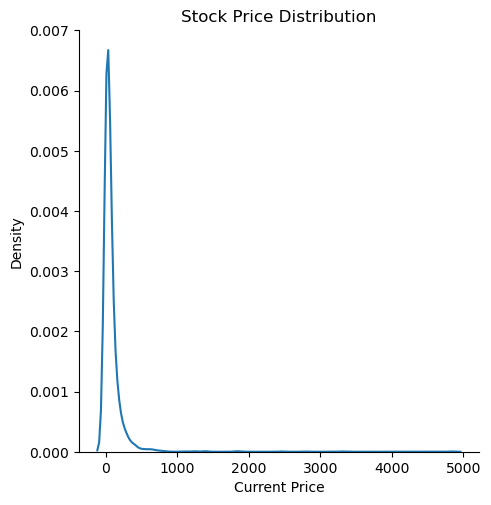

In [8]:
#Plot dependent variable distribution
sns.displot(df_reduced,x="Current Price", kind="kde")
plt.title("Stock Price Distribution")
plt.show()

Outliers are removed to achieve a more normal distribution as can be seen in the updated distribution plot (Outliers defined as > IQR + 1.5*IQR).

In [9]:
#Remove outliers in dependent variable
Q1 = df_reduced['Current Price'].quantile(0.25)
Q3 = df_reduced['Current Price'].quantile(0.75) 
Max_Lim = Q3 + (Q3-Q1)*1.5
df_reduced = df_reduced[df_reduced['Current Price'] <= Max_Lim]

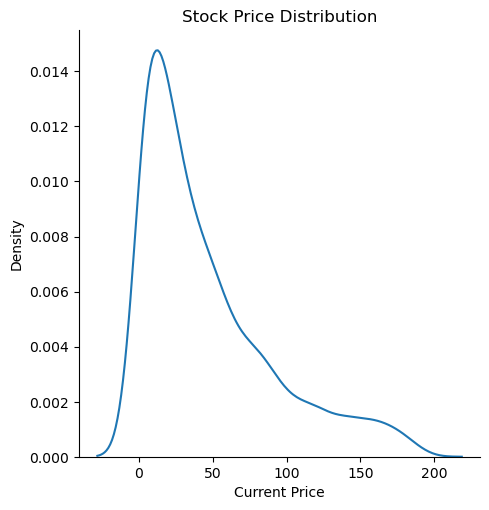

In [10]:
#Plot updated dependent variable distribution
sns.displot(df_reduced,x="Current Price", kind="kde")
plt.title("Stock Price Distribution")
plt.show()

All variables are scaled to a mean = 0 and std = 1 with the exception of the independent variable. Because the primary model metric going foward will be the mean absolute percentage error, it will be important to maintain the current scale of the independent variable to preserve the accuracy of model scoring.

In [11]:
#Standardize independent variable data
numeric_cols = [i for i in numeric_vars if i in df_reduced.columns]
scaler = StandardScaler()
df_reduced[numeric_cols] = scaler.fit_transform(df_reduced[numeric_cols])

## Analysis

An optimized random forest can be difficult to construct due to its complexity. In order to efficiently discern optimal parameters, a structured approach is taken. Feature importances are first calculated using a default random forest model. Using the sorted feature importance list, each model size (by variable count) is tested for performance using a training and test set for analysis. Using the results from this process, the optimal variable count and variable names are deduced. Because there is a high level of data sparsity in the original data set, the raw data is then re-cleaned using only the selected variables in order to reduce data loss due to missing values. 

The prepared dataset is then split into training and test sets to tune the final model. A grid search is then used to hypertune the list of relevant model parameters. In this process each parameter combination is tested and scored for performance. The output parameters are used to create the final model.

For model performance analysis, the primary metric is mean absolute percentage variance. This metric calculates the mean of all prediction errors as calculated by the absolute value of the error as a percentage of the true independent variable value. This metric is appropriate for stock price analysis because stock price fluctuations are primarily calculated as a percentage. A five dollar increase on a high value stock  is not equal to a similar increase on a low value stock and this metric accurately accounts for that. 

***Process Overview:***
- Calculate Feature importance
- Dimensionality reduction
- Reduced data set reformulation
- Model parameter tuning
- Model performance

The first step in dimensionality reduction is to calculate the repsective feature importances in a random forest regression model. This is done using the complete dataset in the default model settings.

In [12]:
#TrainTestdf_model
X1 = df_reduced.drop(['Current Price'], axis = 1)
y1 = df_reduced['Current Price']

# Create default model
test_model = RandomForestRegressor()

#Train the model
test_model.fit(X1, y1);

# Get numerical feature importances
f_importance = list(test_model.feature_importances_)
Results = pd.DataFrame(columns = ["Variable", "Importance"])
Results.Variable = X1.columns
Results.Importance = list(test_model.feature_importances_)
Results = Results.sort_values(by=['Importance'],ascending=False)
Results = Results.reset_index(drop=True)
Results.index

#Add cumulative feature importance
c_list = []
c_val = 0

for i in Results['Importance']:
    c_val += i
    c_list.append(c_val)
    
Results['Cumulative'] = c_list

#Print Results
Results[:20]

,Variable,Importance,Cumulative
0,Forward EPS,0.480366,0.480366
1,Enterprise Value,0.129950,0.610316
2,Enterprise To EBITDA,0.087814,0.698130
3,Enterprise To Revenue,0.050930,0.749060
4,Revenue Per Share,0.036849,0.785909
5,Shares Outstanding,0.035645,0.821554
6,Trailing EPS,0.019305,0.840859
7,Total Debt,0.017179,0.858038
8,Total Cash Per Share,0.014435,0.872473
9,Debt To Equity,0.007805,0.880277


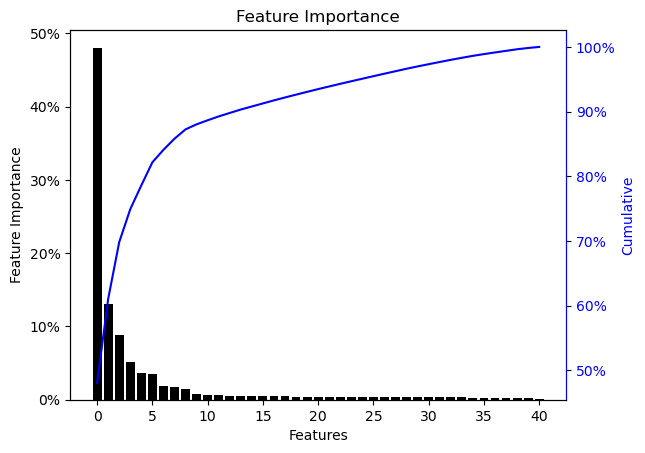

In [13]:
#Plot Results
color1 = "k"
color2 = "blue"

fig, ax1 = plt.subplots()
line1 = ax1.bar(Results.index,Results['Importance'],label = 'Feature Importance',color = color1)
ax1.set_ylabel("Feature Importance",color = color1)
ax1.set_xlabel("Features")
plt.title("Feature Importance")
ax1.tick_params(axis="y", labelcolor = color1)
ax1.spines['left'].set_color(color1)
ax2 = ax1.twinx()
line2 = ax2.plot(Results.index,Results['Cumulative'],label = 'Cumulative',color = color2)
ax2.set_ylabel("Cumulative",color = color2)
ax2.tick_params(axis="y", labelcolor = color2)
ax2.spines['right'].set_color(color2)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

As can be seen in the above plot, 90% of the explained variance is contained within the first 10 variables. The highest performing model will likely contain less than 10 variables. To test further, all potential dataset sizes are tested for performance using the sorted list of variables.

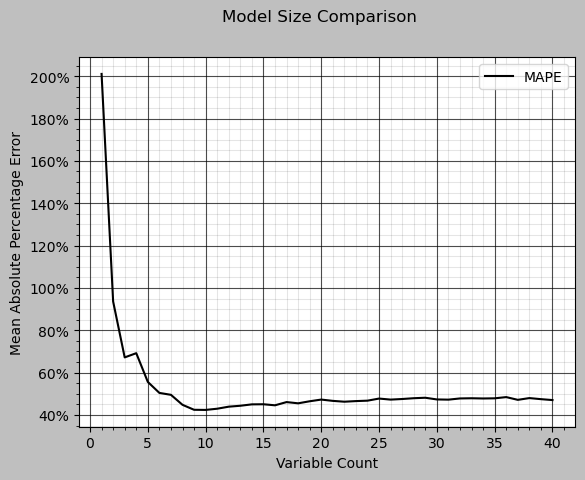

<Figure size 7680x5760 with 0 Axes>

In [14]:
#Create empty dataframe to store results
Results2 = pd.DataFrame(columns = ["Var_cnt", "MAPE"])

#Loop through dataset sizes from 1 to n variables (sorted by feature importance) and return model accurcay
for i in range(1,len(Results)):
    X_n = df_reduced[df_reduced.columns.intersection(Results.Variable.head(i))]
    y_n = df_reduced["Current Price"]

    X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.2, random_state=30)

    #Create model instance
    rf = RandomForestRegressor()
    
    #Train the model
    rf.fit(X_train_n, y_train_n);

    #Create model predictions
    predictions = rf.predict(X_test_n)
    
    #Calculate prediction error percent
    perc_errors = abs(y_test_n - predictions)/abs(y_test_n)
    
    
    #Calculate accuracy
    MAPE = mean_absolute_percentage_error(y_test_n, predictions)
   
    #Store Results
    Results2 = Results2.append({"Var_cnt":  i, "MAPE": MAPE}, ignore_index = True)

#Plot Results
plt.style.use('grayscale')
plt.plot(Results2["Var_cnt"], Results2["MAPE"], label = "MAPE")
plt.suptitle('Model Size Comparison')
plt.xlabel('Variable Count')
plt.ylabel('Mean Absolute Percentage Error')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks([i*5 for i in range(0,9)])
plt.grid(which = 'major', alpha = .7)
plt.grid(which = 'minor', alpha = .1)
plt.minorticks_on()
plt.legend()
plt.figure(dpi=1200)
plt.show()

The highest performing data set size occurs at 9 variables and achieves a mean absolute percentage error of ~44%. 

Data is then re-constructed using only these 9 variables for the purposes of reducing data loss due to missing values contained in unused variables.

In [15]:
#Reduce dataset to optimal size
Reduced_var_list = Results.Variable[:9].to_list()
Reduced_var_list.append("Current Price")

df_reduced2 = df[Reduced_var_list]

#Dropnas into reduced dataset
df_reduced2 = df_reduced2.dropna()

#Remove outliers in dependent variable
Q1 = df_reduced2['Current Price'].quantile(0.25)
Q3 = df_reduced2['Current Price'].quantile(0.75) 
Max_Lim = Q3 + (Q3-Q1)*1.5
df_reduced2 = df_reduced2[df_reduced2['Current Price'] <= Max_Lim]

#Scale data
scaler = StandardScaler()
df_reduced2[Reduced_var_list[:-1]] = scaler.fit_transform(df_reduced2[Reduced_var_list[:-1]])

#Increased data availability
print("Increased Data Availability:", round((len(df_reduced2)-len(df_reduced))/len(df_reduced)*100,2),"%")

#Create feature and response variable subsets
X2 = df_reduced2.drop("Current Price",axis = 1)
y2 = df_reduced2["Current Price"]

#Split Data
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state = 30)

Increased Data Availability: 32.07 %


Data availability is increased by 32% via reduced dimensionality and restructuring. A default random forest regression model is created and tested  with the reduced data set.

In [34]:
default_model = RandomForestRegressor()

# Train the model on training data
default_model.fit(X_train2, y_train2)

#Create model predictions
predictions2 = default_model.predict(X_test2)

#Calculate mean absolute percentage error
MAPE = mean_absolute_percentage_error(y_test2, predictions2)

#Print result
print('MAPE:',round(MAPE*100,2),'%')

MAPE: 46.26 %


The default model produced a mean absolute percentage error of 46.26%. Using a grid search, model performance is tested at all included parameter combinations to tune the model to optimum parameters.

In [35]:
# Create default model
param_search_model = RandomForestRegressor()

#Create parameter grid
param_grid = {'n_estimators': [100,250,500],
              'criterion': ['mse','mae'],
              'min_samples_split': [2,3],
              'min_samples_leaf': [1,2],
              'bootstrap': [True, False]}

#Run grid search
CV_param_search_model = GridSearchCV(estimator=param_search_model, param_grid=param_grid, 
                                     cv= 3, scoring = 'neg_mean_absolute_percentage_error',
                                    verbose = 1)

CV_param_search_model.fit(X_train2, y_train2)

#Print best parameters results
print("Optimal Paramaters:")
print(CV_param_search_model.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Optimal Paramaters:
{'bootstrap': True, 'criterion': 'mse', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


The final model is created using the grid search parameter selection.

In [37]:
final_model = RandomForestRegressor(bootstrap = True, n_estimators = 100,
                                    min_samples_leaf = 2, min_samples_split = 2,
                                    criterion="mse")

# Train the model on training data
final_model.fit(X_train2, y_train2)

#Create model predictions
predictions2 = final_model.predict(X_test2)

#Calculate mean absolute percentage error
MAPE = mean_absolute_percentage_error(y_test2, predictions2)

#Print result
print('MAPE:',round(MAPE*100,2),'%')

MAPE: 45.04 %


A mean absolute percentage error of 45.04% was achieved - a slight improvement over the default model (45.69%).

To translate the error value into a more applicable format, the model accuracy is calculated at each level of allowed percentage variance. For example - If we consider an accurate prediction <= 20% absolute percentage variance, the accuracy is the rate at which predictions fall within this criteria.

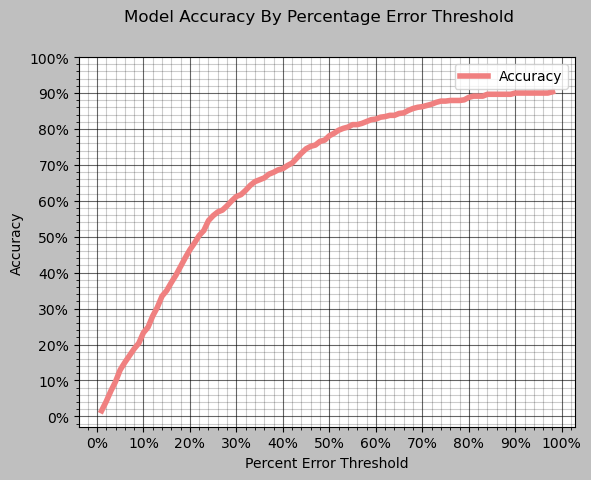

<Figure size 7680x5760 with 0 Axes>

In [38]:
#plot accuracy by variance threshold
perc_errors = abs(y_test2-predictions2)/y_test2

threshold_list = [round(i/100,2) for i in range(1,99)]
accuracy_list = []

for i in threshold_list:
    accu = len([x for x in perc_errors if x <= i])/len(y_test2)
    accuracy_list.append(accu)

#Create data frame
accu_df = pd.DataFrame()   
accu_df["Threshold"] = threshold_list
accu_df["Accuracy"] = accuracy_list

plt.style.use('grayscale')
plt.plot(accu_df["Threshold"], accu_df["Accuracy"], label = "Accuracy", color='lightcoral',linewidth=4)
plt.suptitle("Model Accuracy By Percentage Error Threshold")
plt.ylabel('Accuracy')
plt.xlabel('Percent Error Threshold')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.xticks([i/10 for i in range(0,11)])
plt.yticks([i/10 for i in range(0,11)])
plt.grid(which = 'major', alpha = .6)
plt.grid(which = 'minor', alpha = .2)
plt.minorticks_on()
plt.legend()
plt.figure(dpi=1200)
plt.show()

In [39]:
#print summary
accu_df[accu_df['Threshold'].isin([.1,.2,.3,.4,.5])]

,Threshold,Accuracy
9,0.1,0.232759
19,0.2,0.463793
29,0.3,0.612069
39,0.4,0.689655
49,0.5,0.781034


## Data Summary and Implications

***Model Variables***

The final model uses 9 of the 50 available features:

- ***Forward EPS***: Earnings per share (EPS) is calculated as a company's profit divided by the outstanding shares of its common stock (Fernando, 2021).


- ***Enterprise Value***: Enterprise value (EV) is a measure of a company's total value, often used as a more comprehensive alternative to equity market capitalization (Fernando, 2021).


- ***Enterprise To EBITDA***: The EBITDA/EV multiple is a financial valuation ratio that measures a company's return on investment (ROI) (Kenton, 2021).


- ***Enterprise To Revenue***: The enterprise value-to-revenue multiple (EV/R) is a measure of the value of a stock that compares a company's enterprise value to its revenue (Hargrave, 2021).


- ***Revenue Per Share***: Sales per share is a ratio that computes the total revenue earned per share over a designated period, whether quarterly, semi-annually, annually, or trailing twelve months (TTM) (Kenton, 2021).


- ***Shares Outstanding***: Shares outstanding refer to a company's stock currently held by all its shareholders, including share blocks held by institutional investors and restricted shares owned by the company’s officers and insiders (Chen, 2021).


- ***Trailing EPS***: Trailing earnings per share (EPS) is a company's earnings generated over a prior period (often a fiscal year) reported on a per-share basis (Mitchell, 2021).


- ***Total Cash Per Share***: Cash per share (CPS) measures how much cash a company has on hand on a per-share basis (Bloomenthal, 2021).


- ***Total Debt***: Total liabilities are the combined debts and obligations that an individual or company owes to outside parties (Liberto, 2020).

***Results***

The tuned random forest regression model produced a final mean absolute percentage error of 45.44%. This value indicates average absolute error as a fraction of the respective stock price. 

In practical application, using an allowed variance of 20%, the model predicts stock price correctly at a rate of 46.37%.

The model results establish a correlation between financial data and stock price; however, the predictive value is weak.


***Limitation***

The model is limited by data availability. There are several forces that affect stock price fluctuations that are not contained with in financial data.


***Recommendation***

At an average percentage error of close to 50%, the model is likely not suitable for identifying stocks that are under or over-valued with confidence. The predictions should not be used to make decisions about which stocks are under or over-valued.


## Bibliography

Fernando,J. (2021, 10 13). Earnings Per Share (EPS). Retrieved from https://www.investopedia.com/terms/e/eps.asp

Fernando,J. (2021, 2 20). Enterprise Value (EV). Retrieved from https://www.investopedia.com/terms/e/enterprisevalue.asp

Kenton,W. (2021, 2 27). EBITDA/EV Multiple. Retrieved from https://www.investopedia.com/terms/e/ebitda-ev-multiple.asp

Hargrave,M. (2021, 2 27). Enterprise-Value-to-Revenue (EV/R) Multiple. Retrieved from https://www.investopedia.com/terms/e/ev-revenue-multiple.asp

Kenton,W. (2021, 6 26). Sales Per Share. Retrieved from https://www.investopedia.com/terms/s/salespershare.asp

Chen,J. (2021, 2 28). Shares Outstanding. Retrieved from https://www.investopedia.com/terms/o/outstandingshares.asp

Mitchell,C. (2021, 8 27). Trailing Earnings Per Share (EPS). Retrieved from https://www.investopedia.com/terms/t/trailingeps.asp

Bloomenthal,A. (2021, 6 26). Cash Per Share. Retrieved from https://www.investopedia.com/terms/c/cash-per-share.asp

Liberto,D. (2020, 11 23). Total Liabilities. Retrieved from https://www.investopedia.com/terms/t/total-liabilities.asp